In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directory where arrays are saved
directory = '/content/drive/MyDrive/arrays27'

# File paths
x_train_path = os.path.join(directory, 'x_train.npy')
x_test_path = os.path.join(directory, 'x_test.npy')
x_val_path = os.path.join(directory, 'x_val.npy')
y_train_path = os.path.join(directory, 'y_train.npy')
y_test_path = os.path.join(directory, 'y_test.npy')
y_val_path = os.path.join(directory, 'y_val.npy')

# Load arrays
x_train = np.load(x_train_path)
x_test = np.load(x_test_path)
x_val = np.load(x_val_path)
y_train = np.load(y_train_path)
y_test = np.load(y_test_path)
y_val = np.load(y_val_path)

print(f"Loaded data from {directory}")
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

Loaded data from /content/drive/MyDrive/arrays27
(3751, 299, 299, 3) (1042, 299, 299, 3) (417, 299, 299, 3) (3751,) (1042,) (417,)


ENSEMBLE-2 (VGG16 + resnet50 + xception)

  Loading the base models


In [ ]:
mobilenet = load_model('/content/drive/MyDrive/Models/VGG16_0.hdf5')
resnet50 = load_model('/content/drive/MyDrive/Models/Resnet50.hdf5')
inceptionv3 = load_model('/content/drive/MyDrive/Models/Xception.hdf5')

Generate base models predictions aand combine them

In [ ]:
def get_model_predictions(model, data):
    return model.predict(data,batch_size=64)

# Generate predictions for the train set
mobilenet_train_preds = get_model_predictions(mobilenet, x_train)
resnet50_train_preds = get_model_predictions(resnet50, x_train)
inceptionv3_train_preds = get_model_predictions(inceptionv3, x_train)

# Generate predictions for the validation set
mobilenet_val_preds = get_model_predictions(mobilenet, x_val)
resnet50_val_preds = get_model_predictions(resnet50, x_val)
inceptionv3_val_preds = get_model_predictions(inceptionv3, x_val)


7/7 [==============================] - 9s 2s/step


In [ ]:
# Combine the train and validation predictions
combined_train_preds = np.concatenate(
    [mobilenet_train_preds, resnet50_train_preds, inceptionv3_train_preds],
    axis=1
)

combined_val_preds = np.concatenate(
    [mobilenet_val_preds, resnet50_val_preds, inceptionv3_val_preds],
    axis=1
)

Training meta classifier (logistic regression model)
Stacking Ensemble Model

In [ ]:
# Initialize and train the meta-classifier
meta_classifier = LogisticRegression(max_iter=1000)
meta_classifier.fit(combined_train_preds, y_train)

# Generate predictions with the meta-classifier on the validation set
meta_val_predictions = meta_classifier.predict(combined_val_preds)


Validation set results

In [ ]:
from sklearn.metrics import log_loss, accuracy_score

# Evaluate the meta-classifier on the validation set
val_preds = meta_classifier.predict_proba(combined_val_preds)
val_loss = log_loss(y_val, val_preds)
val_accuracy = accuracy_score(y_val, meta_val_predictions)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.0985
Validation Accuracy: 0.9760


In [ ]:
# Evaluate the meta-classifier on the validation set
print(classification_report(y_val, meta_val_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix
cm = confusion_matrix(y_val, meta_val_predictions)
print("Confusion Matrix:\n", cm)

# Save the meta-classifier
meta_model_path = '/content/drive/MyDrive/Models/meta_classifier.pkl'
joblib.dump(meta_classifier, meta_model_path)
print(f"Meta-model saved to {meta_model_path}")


                 precision    recall  f1-score   support

         Normal       0.99      0.96      0.98       103
 Covid_positive       0.97      0.98      0.98       105
   Lung_Opacity       0.96      0.97      0.97       115
Viral_Pneumonia       0.99      0.99      0.99        94

       accuracy                           0.98       417
      macro avg       0.98      0.98      0.98       417
   weighted avg       0.98      0.98      0.98       417

Confusion Matrix:
 [[ 99   0   4   0]
 [  0 103   1   1]
 [  0   3 112   0]
 [  1   0   0  93]]
Meta-model saved to /content/drive/MyDrive/Models/meta_classifier.pkl


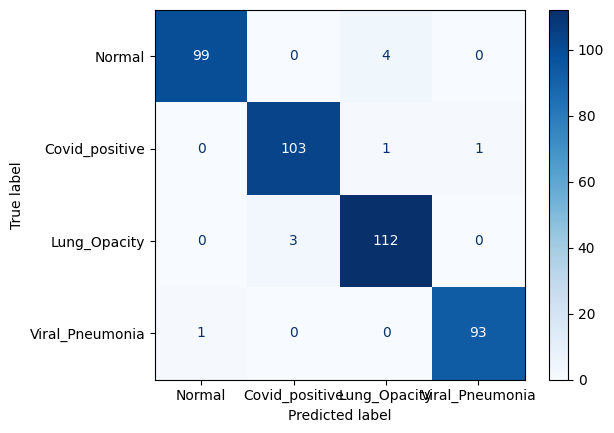

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Test Results

In [ ]:
# Now for testing on the test set
mobilenet_test_preds = get_model_predictions(mobilenet, x_test)
resnet50_test_preds = get_model_predictions(resnet50, x_test)
inceptionv3_test_preds = get_model_predictions(inceptionv3, x_test)

combined_test_preds = np.concatenate(
    [mobilenet_test_preds, resnet50_test_preds, inceptionv3_test_preds],
    axis=1
)

# Test labels
# test_labels = np.argmax(y_test, axis=1)

# Generate predictions with the meta-classifier on the test set
meta_test_predictions = meta_classifier.predict(combined_test_preds)

# Evaluate the meta-classifier on the test set
print(classification_report(y_test, meta_test_predictions, target_names=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']))

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, meta_test_predictions)
print("Confusion Matrix:\n", cm_test)

33/33 [==============================] - 10s 310ms/step
                 precision    recall  f1-score   support

         Normal       0.97      0.96      0.96       274
 Covid_positive       0.98      0.97      0.98       249
   Lung_Opacity       0.94      0.98      0.96       256
Viral_Pneumonia       0.99      0.97      0.98       263

       accuracy                           0.97      1042
      macro avg       0.97      0.97      0.97      1042
   weighted avg       0.97      0.97      0.97      1042

Confusion Matrix:
 [[263   1   8   2]
 [  1 242   6   0]
 [  2   2 252   0]
 [  6   1   1 255]]


In [ ]:
# Generate predictions with the meta-classifier on the test set
test_preds = meta_classifier.predict_proba(combined_test_preds)
test_loss = log_loss(y_test, test_preds)
test_accuracy = accuracy_score(y_test, meta_test_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0895
Test Accuracy: 0.9712


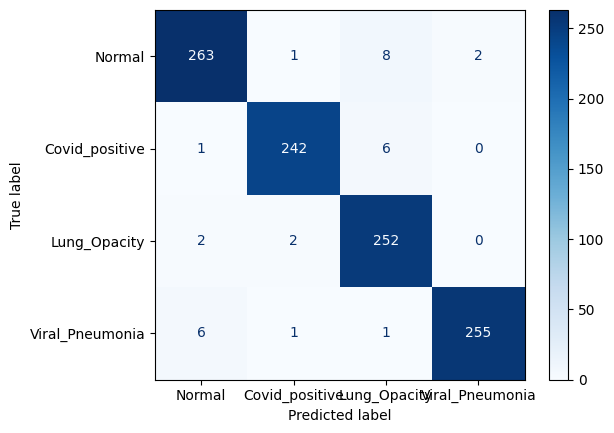

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Boosting ensemble techniques**
  1. XGBoost

In [ ]:
# Combine predictions into feature matrices
X_train_combined = np.hstack((resnet50_train_preds, mobilenet_train_preds, inceptionv3_train_preds))
X_val_combined = np.hstack((resnet50_val_preds, mobilenet_val_preds, inceptionv3_val_preds))

In [ ]:
y_train.shape

(3751,)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create and train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_combined, y_train)  # Use y_train as 1D array

# Predict on validation set
y_pred = xgb_model.predict(X_val_combined)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))  # Use y_val as 1D array


XGBoost Accuracy: 0.9688249400479616


2. LightBGM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Create and train LightGBM model
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=-1, random_state=82)
lgb_model.fit(X_train_combined,y_train)  # Use y_train as 1D array

# Predict on validation set
y_pred = lgb_model.predict(X_val_combined)

# Evaluate
print("LightGBM Accuracy:", accuracy_score(y_val, y_pred))  # Use y_val as 1D array


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 3751, number of used features: 12
[LightGBM] [Info] Start training from score -1.402149
[LightGBM] [Info] Start training from score -1.377535
[LightGBM] [Info] Start training from score -1.384962
[LightGBM] [Info] Start training from score -1.380711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po


3. Voting ensemble technique

In [ ]:
vgg_model = load_model('/content/drive/MyDrive/Models/VGG16_0.hdf5')
resnet_model = load_model('/content/drive/MyDrive/Models/Resnet50.hdf5')
xception_model = load_model('/content/drive/MyDrive/Models/Xception.hdf5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Define a wrapper class for pre-trained Keras models
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        # Predict class labels
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        # Predict probabilities
        return self.model.predict(X)

# Wrap the models
resnet_clf = KerasClassifierWrapper(resnet_model)
vgg_clf = KerasClassifierWrapper(vgg_model)
xception_clf = KerasClassifierWrapper(xception_model)

# Function to get ensemble predictions by majority vote
def ensemble_predict(X, classifiers):
    # Get predictions from each model
    predictions = [clf.predict(X) for clf in classifiers]

    # Stack predictions and take a majority vote
    predictions = np.array(predictions)
    # Shape: (num_classifiers, num_samples)
    majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return majority_vote

# Get predictions for validation data
classifiers = [resnet_clf, vgg_clf, xception_clf]
y_pred_val = ensemble_predict(x_val, classifiers)


# Evaluate the ensemble predictions
val_accuracy = accuracy_score(y_val, y_pred_val)

print(f"Voting Ensemble Validation Accuracy: {val_accuracy:.4f}")


14/14 [==============================] - 12s 257ms/step
Voting Ensemble Validation Accuracy: 0.9736


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Define a wrapper class for pre-trained Keras models
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        # Predict class labels
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        # Predict probabilities
        return self.model.predict(X)

# Wrap the models
resnet_clf = KerasClassifierWrapper(resnet_model)
vgg_clf = KerasClassifierWrapper(vgg_model)
xception_clf = KerasClassifierWrapper(xception_model)

# Function to get ensemble predictions by majority vote
def ensemble_predict(X, classifiers):
    # Get predictions from each model
    predictions = [clf.predict(X) for clf in classifiers]

    # Stack predictions and take a majority vote
    predictions = np.array(predictions)
    # Shape: (num_classifiers, num_samples)
    majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return majority_vote

# Evaluate on test data
# Assuming x_test and y_test are your test features and labels
y_pred_test = ensemble_predict(x_test, [resnet_clf, vgg_clf, xception_clf])

# Convert y_test to 1D labels
# y_test_1d = np.argmax(y_test, axis=1)

# Evaluate the ensemble predictions
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Voting Ensemble Test Accuracy: {test_accuracy:.4f}")


33/33 [==============================] - 11s 346ms/step
Voting Ensemble Test Accuracy: 0.9712


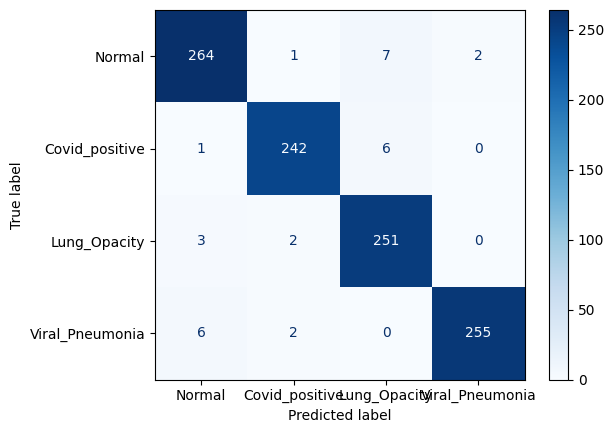

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
